## Training Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('./spam_training_data.csv')

In [3]:
new_data = pd.read_csv('./dataset.csv')

In [26]:
add_data = pd.read_csv('./Dataadditional.csv')

In [4]:
new_data['is_complaint']=1

In [27]:
add_data['is_complaint']=1

In [5]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thori\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
stop_words = list(stopwords.words("indonesian"))

In [76]:
import json
# Save the list of stop words into a JSON file
with open('stop_words.json', 'w') as file:
    json.dump(stop_words, file)

In [42]:
factory = StemmerFactory()
lemmatizer = factory.create_stemmer()

In [329]:
lemmatizer

In [43]:
def clean_complaint(complaint):
    # Remove usernames after '@'
    complaint = re.sub(r'@\w+', '', complaint)
    # Remove URLs
    complaint = re.sub(r'http\S+', '', complaint)
    # Remove punctuation and special symbols (commas, periods, etc.)
    complaint = re.sub(r'[^\w\s]', '', complaint)
    # Remove extra whitespace
    complaint = re.sub(r'\s+', ' ', complaint).strip()
    # Remove any zero-width characters like 'ㅤ'
    complaint = re.sub(r'[\u200B-\u200D\uFEFF\u3164]+', '', complaint)
    return complaint

In [44]:
def remove_stopwords(complaint):
    complaint = complaint.lower()
     #Tokenize and remove stop words
    words = [word for word in complaint.split() if word not in stop_words]
    # Apply lemmatization
    lemmatized_words = [lemmatizer.stem(word) for word in words]
    return ' '.join(lemmatized_words)

In [9]:
data['complaint'] = data['complaint'].apply(clean_complaint)

In [10]:
data['complaint'] = data['complaint'].apply(remove_stopwords)

In [10]:
new_data['complaint'] = new_data['complaint'].apply(clean_complaint)

In [11]:
new_data['complaint'] = new_data['complaint'].apply(remove_stopwords)

In [28]:
add_data['complaint'] = add_data['complaint'].apply(clean_complaint)

In [29]:
add_data['complaint'] = add_data['complaint'].apply(remove_stopwords)

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thori\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
# Tokenize each complaint
data['tokenized_complaint'] = data['complaint'].apply(word_tokenize)

In [12]:
# Tokenize each complaint
new_data['tokenized_complaint'] = new_data['complaint'].apply(word_tokenize)

In [30]:
# Tokenize each complaint
add_data['tokenized_complaint'] = add_data['complaint'].apply(word_tokenize)

In [31]:
data = pd.concat([data, new_data, add_data], ignore_index=True)

In [32]:
data = data.drop_duplicates(subset=['complaint', 'is_complaint'])

In [38]:
data

,complaint,is_complaint,tokenized_complaint,vectorized
0,iyasih kalo banjir ingin umpat perintah suka b...,1,"['iyasih', 'kalo', 'banjir', 'ingin', 'umpat',...",iyasih kalo banjir ingin umpat perintah suka b...
1,fokus manfaat aja min bahas sampah miris faktu...,0,"['fokus', 'manfaat', 'aja', 'min', 'bahas', 's...",fokus manfaat aja min bahas sampah miris faktu...
2,bocah suka kalo hujan main air hujan hujan tuh...,0,"['bocah', 'suka', 'kalo', 'hujan', 'main', 'ai...",bocah suka kalo hujan main air hujan hujan tuh...
3,pas make sering kena macet ga feeling pleasure...,0,"['pas', 'make', 'sering', 'kena', 'macet', 'ga...",pas make sering kena macet ga feeling pleasure...
4,pesan moral jahil bawah kaisar ambil aset mili...,0,"['pesan', 'moral', 'jahil', 'bawah', 'kaisar',...",pesan moral jahil bawah kaisar ambil aset mili...
...,...,...,...,...
1331,ak mo pindah akun akun udh cemar drama genshin...,1,"[ak, mo, pindah, akun, akun, udh, cemar, drama...",ak mo pindah akun akun udh cemar drama genshin...
1332,aja fantasi idol tolong sadar pake kadang kasi...,1,"[aja, fantasi, idol, tolong, sadar, pake, kada...",aja fantasi idol tolong sadar pake kadang kasi...
1333,timeline cemar videogambar bogel laa adehh tak...,1,"[timeline, cemar, videogambar, bogel, laa, ade...",timeline cemar videogambar bogel laa adehh tak...
1334,suguh dramadrama pilih yg sdh tentu menang hul...,1,"[suguh, dramadrama, pilih, yg, sdh, tentu, men...",suguh dramadrama pilih yg sdh tentu menang hul...


In [39]:
data.to_csv('./spam_training_data.csv', index=False)

In [3]:
X = data['complaint']
y = data['is_complaint']

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression Model with Vectorizer

In [219]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
log_losses = []
f1_scores = []
precisions = []
recalls = []

# Initialize vectorizer and classifier
vectorizer = TfidfVectorizer(max_features=500)  # Convert text to numerical features
clf = LogisticRegression()

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the vectorizer on the training data (fit on X_train)
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Train the classifier on the transformed training data
    clf.fit(X_train_vec, y_train)

    # Transform the test data using the fitted vectorizer (do not fit again)
    X_test_vec = vectorizer.transform(X_test)
    
    # Make predictions
    y_pred = clf.predict(X_test_vec)
    y_pred_proba = clf.predict_proba(X_test_vec)  # Probabilities for log loss
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba)
    log_losses.append(loss)
    
    # Calculate F1-score, precision, and recall
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Print average metrics across all folds
print(f"Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")

with open('logistic_regression/logistic_regression_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('logistic_regression/logistic_regression_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)


Accuracy: 0.7186
Log Loss: 0.5626
F1-Score: 0.7092
Precision: 0.7204
Recall: 0.7186


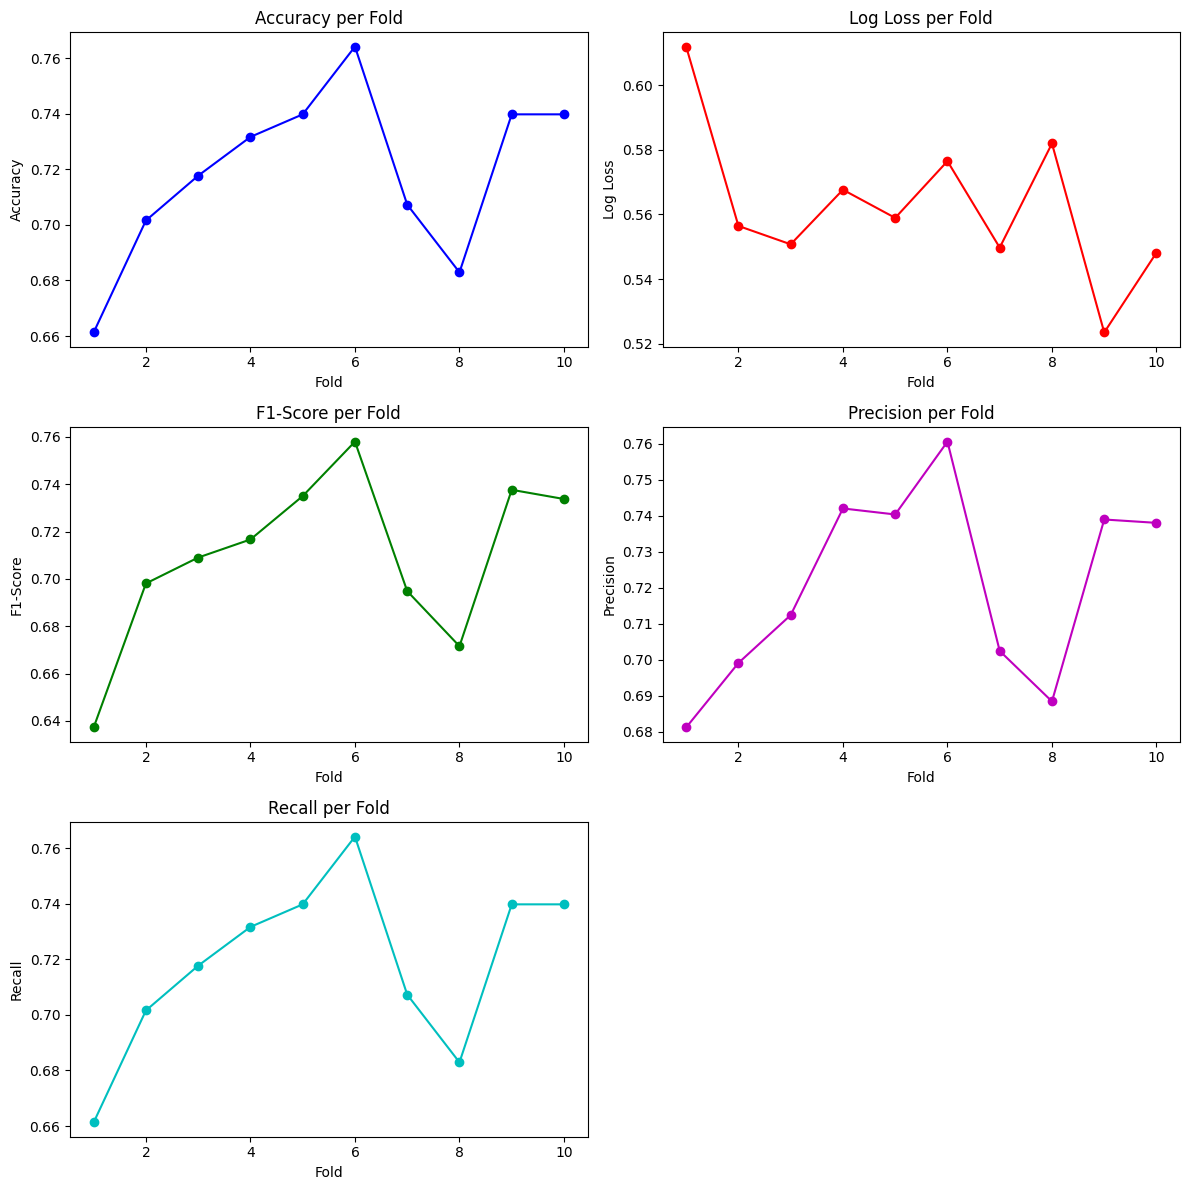


Average Accuracy: 0.7186
Average Log Loss: 0.5626
Average F1-Score: 0.7092
Average Precision: 0.7204
Average Recall: 0.7186


In [220]:
import matplotlib.pyplot as plt

# Plot the metrics for each fold
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(range(1, kf.get_n_splits() + 1), accuracies, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Accuracy per Fold")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("Accuracy")

# Log Loss plot
axes[0, 1].plot(range(1, kf.get_n_splits() + 1), log_losses, marker='o', linestyle='-', color='r')
axes[0, 1].set_title("Log Loss per Fold")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("Log Loss")

# F1-Score plot
axes[1, 0].plot(range(1, kf.get_n_splits() + 1), f1_scores, marker='o', linestyle='-', color='g')
axes[1, 0].set_title("F1-Score per Fold")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("F1-Score")

# Precision plot
axes[1, 1].plot(range(1, kf.get_n_splits() + 1), precisions, marker='o', linestyle='-', color='m')
axes[1, 1].set_title("Precision per Fold")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Precision")

# Recall plot
axes[2, 0].plot(range(1, kf.get_n_splits() + 1), recalls, marker='o', linestyle='-', color='c')
axes[2, 0].set_title("Recall per Fold")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("Recall")

# Hide empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print average metrics across all folds
print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"Average F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Average Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Average Recall: {sum(recalls)/len(recalls):.4f}")

## Logistic Regression Model with Count Vectorizer

In [217]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer  # Import CountVectorizer instead
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import pickle

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
log_losses = []
f1_scores = []
precisions = []
recalls = []

# Initialize vectorizer and classifier
vectorizer = CountVectorizer(max_features=500)  # Use CountVectorizer for text conversion
clf = LogisticRegression()

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the vectorizer on the training data (fit on X_train)
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Train the classifier on the transformed training data
    clf.fit(X_train_vec, y_train)

    # Transform the test data using the fitted vectorizer (do not fit again)
    X_test_vec = vectorizer.transform(X_test)
    
    # Make predictions
    y_pred = clf.predict(X_test_vec)
    y_pred_proba = clf.predict_proba(X_test_vec)  # Probabilities for log loss
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba)
    log_losses.append(loss)
    
    # Calculate F1-score, precision, and recall
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Print average metrics across all folds
print(f"Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")

# Save the model and vectorizer
with open('logistic_regression/logistic_regression_cnt_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('logistic_regression/logistic_regression_cnt_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

Accuracy: 0.7081
Log Loss: 0.6195
F1-Score: 0.7049
Precision: 0.7070
Recall: 0.7081


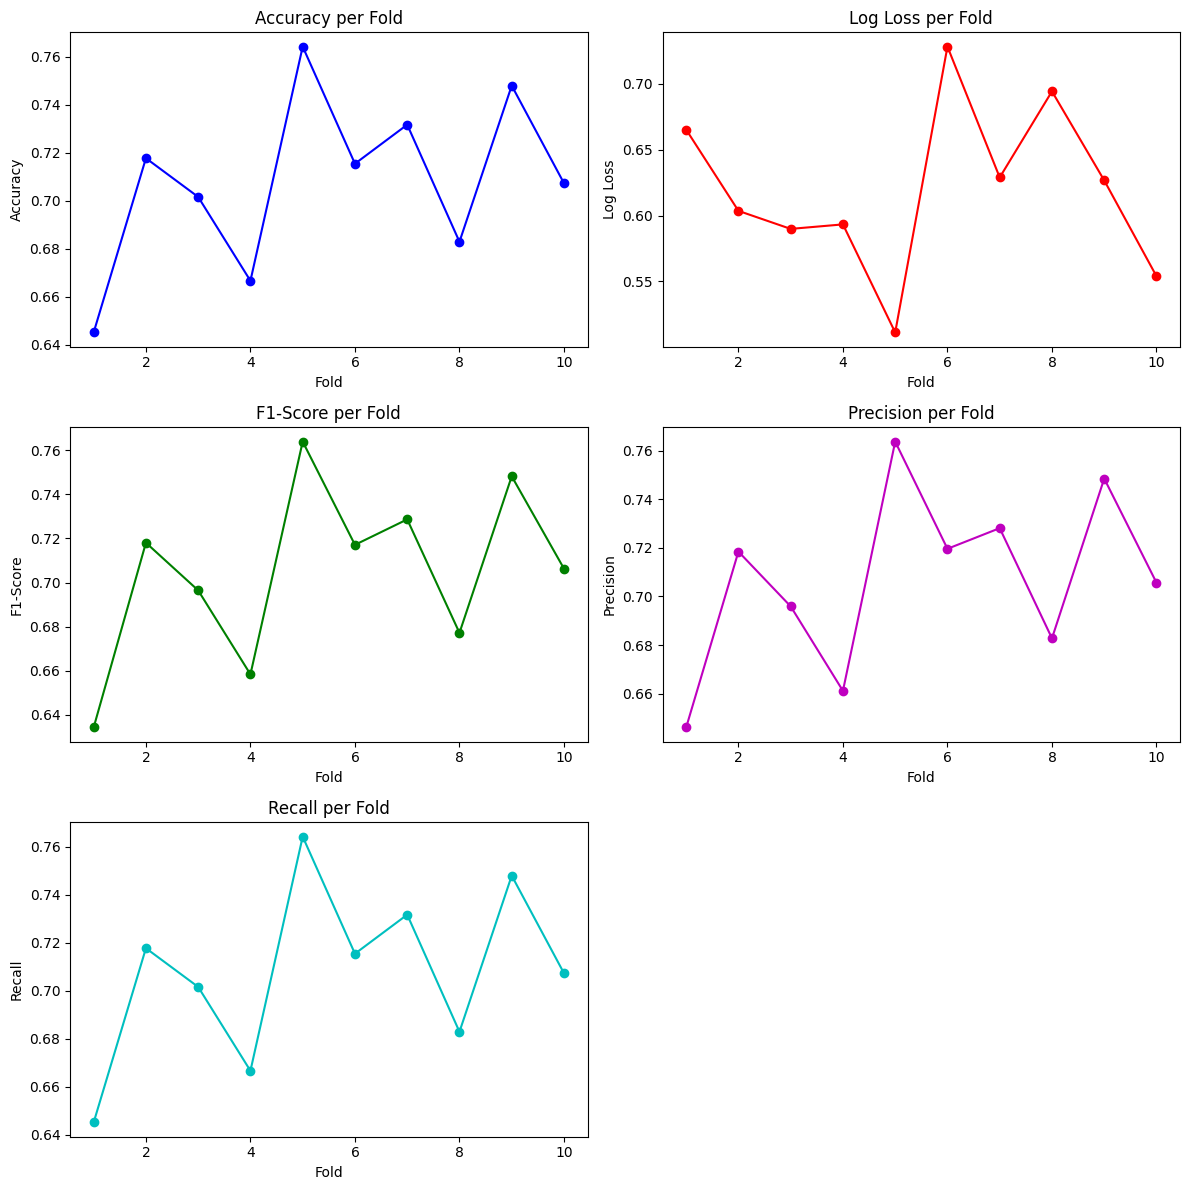


Average Accuracy: 0.7081
Average Log Loss: 0.6195
Average F1-Score: 0.7049
Average Precision: 0.7070
Average Recall: 0.7081


In [218]:
import matplotlib.pyplot as plt

# Plot the metrics for each fold
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(range(1, kf.get_n_splits() + 1), accuracies, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Accuracy per Fold")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("Accuracy")

# Log Loss plot
axes[0, 1].plot(range(1, kf.get_n_splits() + 1), log_losses, marker='o', linestyle='-', color='r')
axes[0, 1].set_title("Log Loss per Fold")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("Log Loss")

# F1-Score plot
axes[1, 0].plot(range(1, kf.get_n_splits() + 1), f1_scores, marker='o', linestyle='-', color='g')
axes[1, 0].set_title("F1-Score per Fold")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("F1-Score")

# Precision plot
axes[1, 1].plot(range(1, kf.get_n_splits() + 1), precisions, marker='o', linestyle='-', color='m')
axes[1, 1].set_title("Precision per Fold")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Precision")

# Recall plot
axes[2, 0].plot(range(1, kf.get_n_splits() + 1), recalls, marker='o', linestyle='-', color='c')
axes[2, 0].set_title("Recall per Fold")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("Recall")

# Hide empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print average metrics across all folds
print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"Average F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Average Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Average Recall: {sum(recalls)/len(recalls):.4f}")

## SVM Model with Vectorizer

In [215]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import KFold

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
log_losses = []
f1_scores = []
precisions = []
recalls = []

# Initialize vectorizer and classifier
vectorizer = TfidfVectorizer(max_features=500)  # Convert text to numerical features
clf = SVC(probability=True)

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the vectorizer on the training data (fit on X_train)
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Train the classifier on the transformed training data
    clf.fit(X_train_vec, y_train)

    # Transform the test data using the fitted vectorizer (do not fit again)
    X_test_vec = vectorizer.transform(X_test)
    
    # Make predictions
    y_pred = clf.predict(X_test_vec)
    y_pred_proba = clf.predict_proba(X_test_vec)  # Probabilities for log loss
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba)
    log_losses.append(loss)
    
    # Calculate F1-score, precision, and recall
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Print average metrics across all folds
print(f"Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")

with open('svm/svm_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('svm/svm_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

Accuracy: 0.7259
Log Loss: 0.5664
F1-Score: 0.7167
Precision: 0.7277
Recall: 0.7259


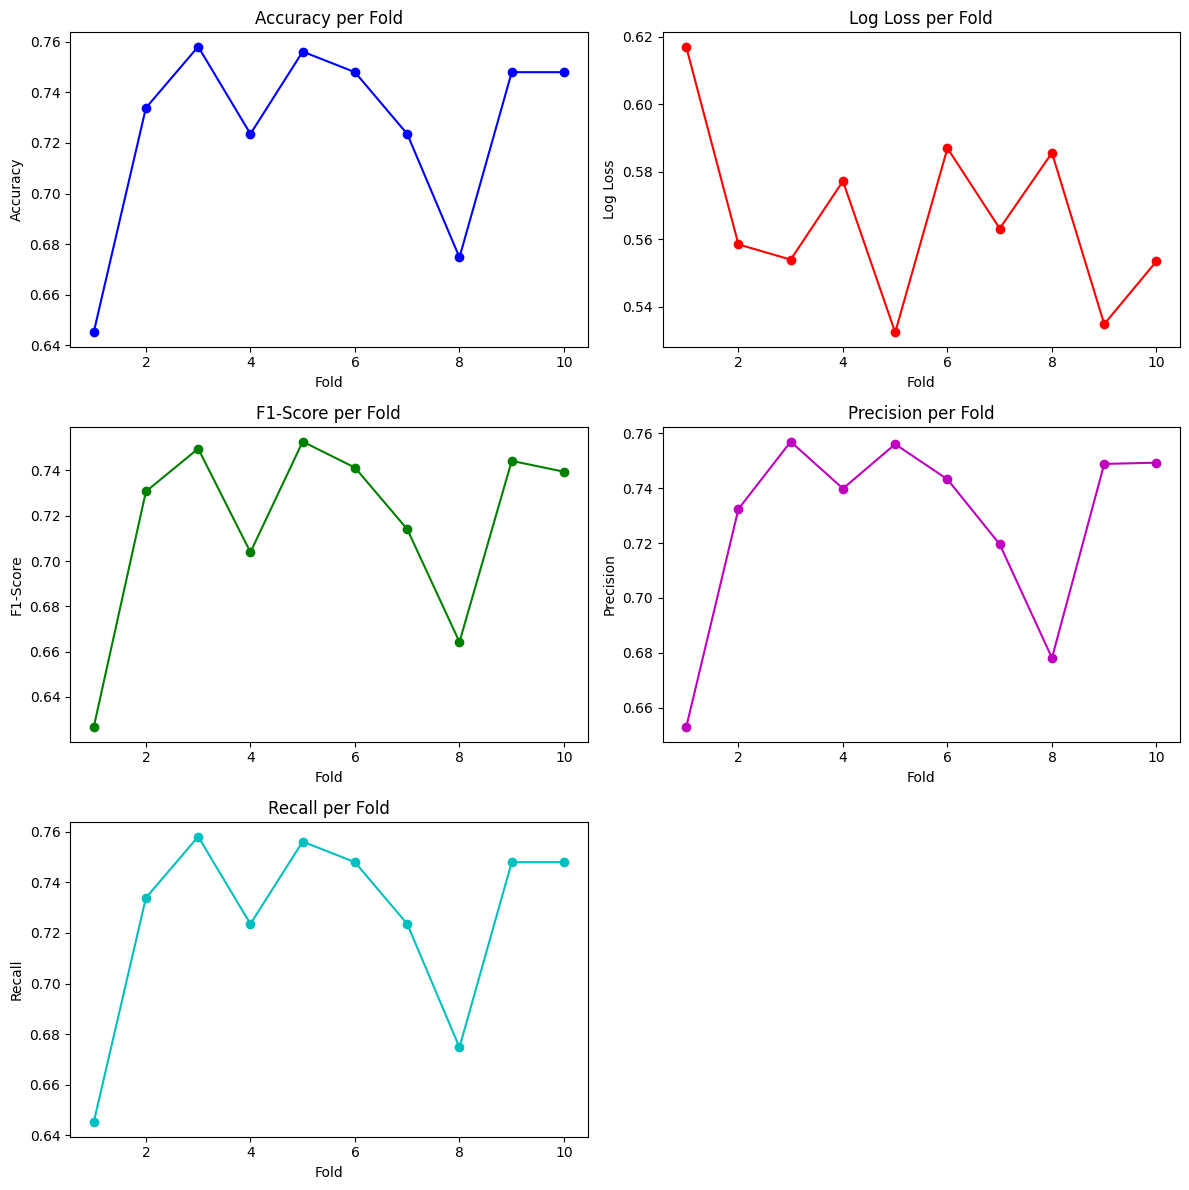


Average Accuracy: 0.7259
Average Log Loss: 0.5664
Average F1-Score: 0.7167
Average Precision: 0.7277
Average Recall: 0.7259


In [216]:
import matplotlib.pyplot as plt

# Plot the metrics for each fold
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(range(1, kf.get_n_splits() + 1), accuracies, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Accuracy per Fold")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("Accuracy")

# Log Loss plot
axes[0, 1].plot(range(1, kf.get_n_splits() + 1), log_losses, marker='o', linestyle='-', color='r')
axes[0, 1].set_title("Log Loss per Fold")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("Log Loss")

# F1-Score plot
axes[1, 0].plot(range(1, kf.get_n_splits() + 1), f1_scores, marker='o', linestyle='-', color='g')
axes[1, 0].set_title("F1-Score per Fold")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("F1-Score")

# Precision plot
axes[1, 1].plot(range(1, kf.get_n_splits() + 1), precisions, marker='o', linestyle='-', color='m')
axes[1, 1].set_title("Precision per Fold")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Precision")

# Recall plot
axes[2, 0].plot(range(1, kf.get_n_splits() + 1), recalls, marker='o', linestyle='-', color='c')
axes[2, 0].set_title("Recall per Fold")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("Recall")

# Hide empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print average metrics across all folds
print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"Average F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Average Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Average Recall: {sum(recalls)/len(recalls):.4f}")

## SVM Model with Count Vectorizer

In [213]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer  # Import CountVectorizer instead
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import pickle

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
log_losses = []
f1_scores = []
precisions = []
recalls = []

# Initialize vectorizer and classifier
vectorizer = CountVectorizer(max_features=500)  # Use CountVectorizer for text conversion
clf = SVC(probability=True)

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the vectorizer on the training data (fit on X_train)
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Train the classifier on the transformed training data
    clf.fit(X_train_vec, y_train)

    # Transform the test data using the fitted vectorizer (do not fit again)
    X_test_vec = vectorizer.transform(X_test)
    
    # Make predictions
    y_pred = clf.predict(X_test_vec)
    y_pred_proba = clf.predict_proba(X_test_vec)  # Probabilities for log loss
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba)
    log_losses.append(loss)
    
    # Calculate F1-score, precision, and recall
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Print average metrics across all folds
print(f"Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")

# Save the model and vectorizer
with open('svm/svm_cnt_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('svm/svm_cnt_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

Accuracy: 0.7307
Log Loss: 0.5481
F1-Score: 0.7166
Precision: 0.7406
Recall: 0.7307


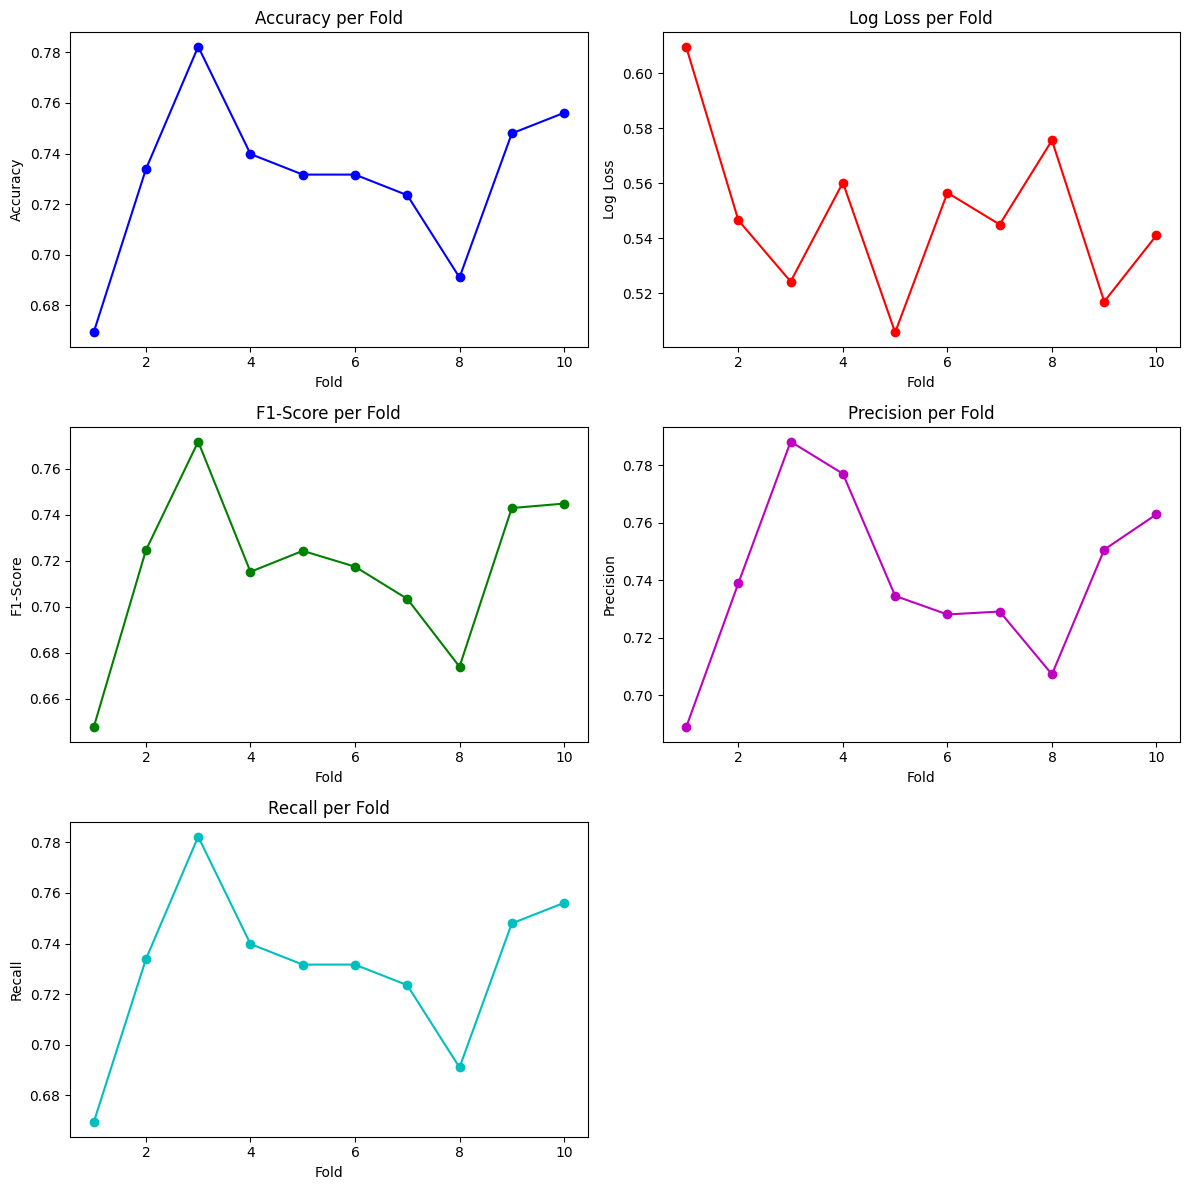


Average Accuracy: 0.7307
Average Log Loss: 0.5481
Average F1-Score: 0.7166
Average Precision: 0.7406
Average Recall: 0.7307


In [214]:
import matplotlib.pyplot as plt

# Plot the metrics for each fold
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(range(1, kf.get_n_splits() + 1), accuracies, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Accuracy per Fold")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("Accuracy")

# Log Loss plot
axes[0, 1].plot(range(1, kf.get_n_splits() + 1), log_losses, marker='o', linestyle='-', color='r')
axes[0, 1].set_title("Log Loss per Fold")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("Log Loss")

# F1-Score plot
axes[1, 0].plot(range(1, kf.get_n_splits() + 1), f1_scores, marker='o', linestyle='-', color='g')
axes[1, 0].set_title("F1-Score per Fold")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("F1-Score")

# Precision plot
axes[1, 1].plot(range(1, kf.get_n_splits() + 1), precisions, marker='o', linestyle='-', color='m')
axes[1, 1].set_title("Precision per Fold")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Precision")

# Recall plot
axes[2, 0].plot(range(1, kf.get_n_splits() + 1), recalls, marker='o', linestyle='-', color='c')
axes[2, 0].set_title("Recall per Fold")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("Recall")

# Hide empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print average metrics across all folds
print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"Average F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Average Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Average Recall: {sum(recalls)/len(recalls):.4f}")

## Random Forest Model with Vectorizer

In [211]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier
from sklearn.model_selection import KFold
import pickle

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
log_losses = []
f1_scores = []
precisions = []
recalls = []

# Initialize vectorizer and classifier
vectorizer = TfidfVectorizer(max_features=500)  # Convert text to numerical features
clf = RandomForestClassifier(random_state=42)  # Change to RandomForestClassifier

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the vectorizer on the training data (fit on X_train)
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Train the classifier on the transformed training data
    clf.fit(X_train_vec, y_train)

    # Transform the test data using the fitted vectorizer (do not fit again)
    X_test_vec = vectorizer.transform(X_test)
    
    # Make predictions
    y_pred = clf.predict(X_test_vec)
    # For Random Forest, there's no predict_proba if it's not a classification with probabilities.
    # If you want log_loss, make sure RandomForestClassifier has `n_jobs` parameter set.
    try:
        y_pred_proba = clf.predict_proba(X_test_vec)  # Probabilities for log loss
    except AttributeError:
        y_pred_proba = clf.predict_proba(X_test_vec)  # Handle this if necessary.
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba)
    log_losses.append(loss)
    
    # Calculate F1-score, precision, and recall
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Print average metrics across all folds
print(f"Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")

# Save the model and vectorizer
with open('random_forest/random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('random_forest/random_forest_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

Accuracy: 0.7219
Log Loss: 0.6221
F1-Score: 0.7164
Precision: 0.7218
Recall: 0.7219


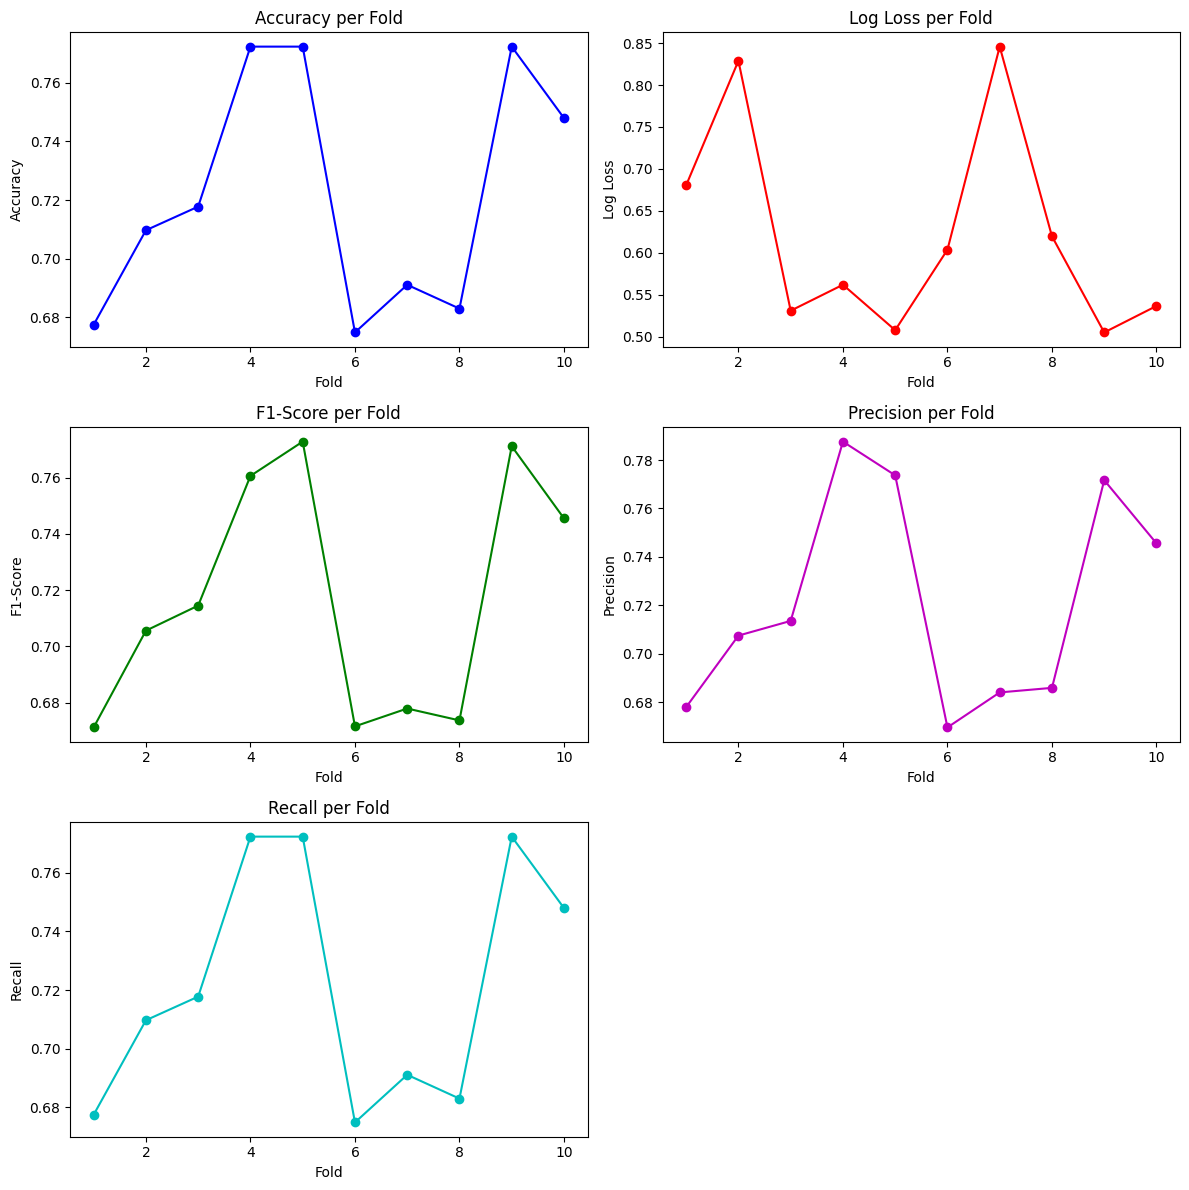


Average Accuracy: 0.7219
Average Log Loss: 0.6221
Average F1-Score: 0.7164
Average Precision: 0.7218
Average Recall: 0.7219


In [212]:
import matplotlib.pyplot as plt

# Plot the metrics for each fold
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(range(1, kf.get_n_splits() + 1), accuracies, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Accuracy per Fold")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("Accuracy")

# Log Loss plot
axes[0, 1].plot(range(1, kf.get_n_splits() + 1), log_losses, marker='o', linestyle='-', color='r')
axes[0, 1].set_title("Log Loss per Fold")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("Log Loss")

# F1-Score plot
axes[1, 0].plot(range(1, kf.get_n_splits() + 1), f1_scores, marker='o', linestyle='-', color='g')
axes[1, 0].set_title("F1-Score per Fold")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("F1-Score")

# Precision plot
axes[1, 1].plot(range(1, kf.get_n_splits() + 1), precisions, marker='o', linestyle='-', color='m')
axes[1, 1].set_title("Precision per Fold")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Precision")

# Recall plot
axes[2, 0].plot(range(1, kf.get_n_splits() + 1), recalls, marker='o', linestyle='-', color='c')
axes[2, 0].set_title("Recall per Fold")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("Recall")

# Hide empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print average metrics across all folds
print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"Average F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Average Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Average Recall: {sum(recalls)/len(recalls):.4f}")

## Random Forest Model with Count Vectorizer

In [209]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer  # Import CountVectorizer
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier
from sklearn.model_selection import KFold
import pickle

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
log_losses = []
f1_scores = []
precisions = []
recalls = []

# Initialize vectorizer and classifier
vectorizer = CountVectorizer(max_features=500)  # Use CountVectorizer for text conversion
clf = RandomForestClassifier(random_state=42)  # Use RandomForestClassifier

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the vectorizer on the training data (fit on X_train)
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Train the classifier on the transformed training data
    clf.fit(X_train_vec, y_train)

    # Transform the test data using the fitted vectorizer (do not fit again)
    X_test_vec = vectorizer.transform(X_test)
    
    # Make predictions
    y_pred = clf.predict(X_test_vec)
    y_pred_proba = clf.predict_proba(X_test_vec)  # Probabilities for log loss
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba)
    log_losses.append(loss)
    
    # Calculate F1-score, precision, and recall
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Print average metrics across all folds
print(f"Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")

# Save the model and vectorizer
with open('random_forest/random_forest_cnt_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('random_forest/random_forest_cnt_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)


Accuracy: 0.7251
Log Loss: 0.5974
F1-Score: 0.7216
Precision: 0.7257
Recall: 0.7251


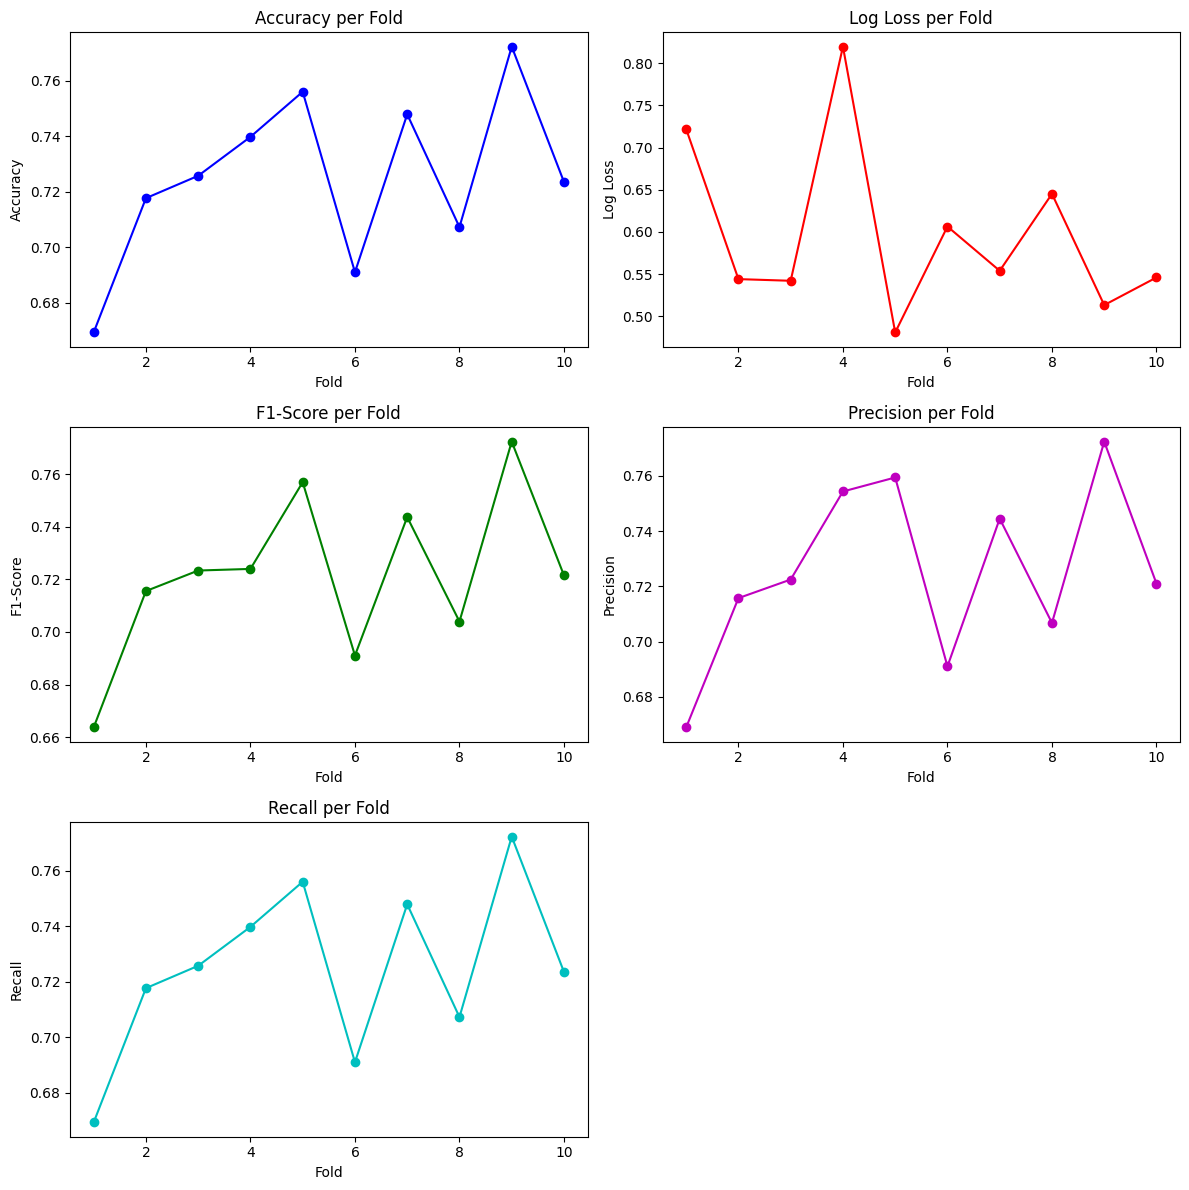


Average Accuracy: 0.7251
Average Log Loss: 0.5974
Average F1-Score: 0.7216
Average Precision: 0.7257
Average Recall: 0.7251


In [210]:
import matplotlib.pyplot as plt

# Plot the metrics for each fold
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(range(1, kf.get_n_splits() + 1), accuracies, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Accuracy per Fold")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("Accuracy")

# Log Loss plot
axes[0, 1].plot(range(1, kf.get_n_splits() + 1), log_losses, marker='o', linestyle='-', color='r')
axes[0, 1].set_title("Log Loss per Fold")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("Log Loss")

# F1-Score plot
axes[1, 0].plot(range(1, kf.get_n_splits() + 1), f1_scores, marker='o', linestyle='-', color='g')
axes[1, 0].set_title("F1-Score per Fold")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("F1-Score")

# Precision plot
axes[1, 1].plot(range(1, kf.get_n_splits() + 1), precisions, marker='o', linestyle='-', color='m')
axes[1, 1].set_title("Precision per Fold")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Precision")

# Recall plot
axes[2, 0].plot(range(1, kf.get_n_splits() + 1), recalls, marker='o', linestyle='-', color='c')
axes[2, 0].set_title("Recall per Fold")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("Recall")

# Hide empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print average metrics across all folds
print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"Average F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Average Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Average Recall: {sum(recalls)/len(recalls):.4f}")

## Naive Bayes Model with Vectorizer

In [205]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB  # Import Naive Bayes classifier
from sklearn.model_selection import KFold
import pickle

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
log_losses = []
f1_scores = []
precisions = []
recalls = []

# Initialize vectorizer and classifier
vectorizer = TfidfVectorizer(max_features=500)  # Convert text to numerical features
clf = MultinomialNB()  # Using Multinomial Naive Bayes classifier

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the vectorizer on the training data (fit on X_train)
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Train the classifier on the transformed training data
    clf.fit(X_train_vec, y_train)

    # Transform the test data using the fitted vectorizer (do not fit again)
    X_test_vec = vectorizer.transform(X_test)
    
    # Make predictions
    y_pred = clf.predict(X_test_vec)
    # Naive Bayes classifier doesn't use predict_proba for log loss in the same way as others,
    # but you can use predict_proba in MultinomialNB for log loss if needed.
    y_pred_proba = clf.predict_proba(X_test_vec)  # Probabilities for log loss
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba)
    log_losses.append(loss)
    
    # Calculate F1-score, precision, and recall
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Print average metrics across all folds
print(f"Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")

# Save the model and vectorizer
with open('naive_bayes/naive_bayes_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('naive_bayes/naive_bayes_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)


Accuracy: 0.7048
Log Loss: 0.5806
F1-Score: 0.6948
Precision: 0.7060
Recall: 0.7048


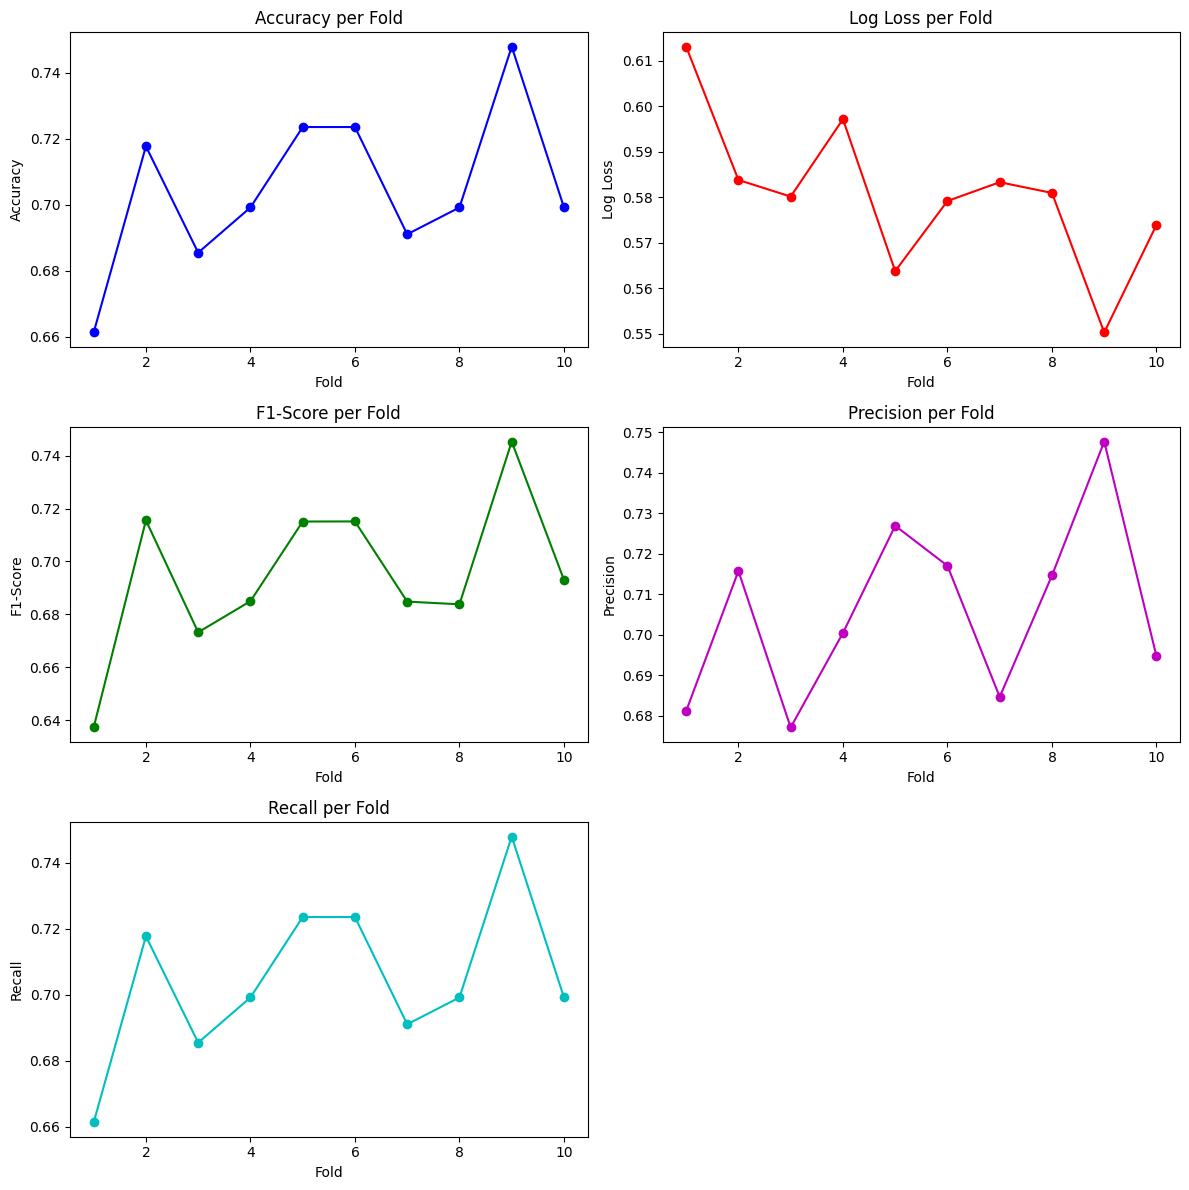


Average Accuracy: 0.7048
Average Log Loss: 0.5806
Average F1-Score: 0.6948
Average Precision: 0.7060
Average Recall: 0.7048


In [206]:
import matplotlib.pyplot as plt

# Plot the metrics for each fold
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(range(1, kf.get_n_splits() + 1), accuracies, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Accuracy per Fold")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("Accuracy")

# Log Loss plot
axes[0, 1].plot(range(1, kf.get_n_splits() + 1), log_losses, marker='o', linestyle='-', color='r')
axes[0, 1].set_title("Log Loss per Fold")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("Log Loss")

# F1-Score plot
axes[1, 0].plot(range(1, kf.get_n_splits() + 1), f1_scores, marker='o', linestyle='-', color='g')
axes[1, 0].set_title("F1-Score per Fold")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("F1-Score")

# Precision plot
axes[1, 1].plot(range(1, kf.get_n_splits() + 1), precisions, marker='o', linestyle='-', color='m')
axes[1, 1].set_title("Precision per Fold")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Precision")

# Recall plot
axes[2, 0].plot(range(1, kf.get_n_splits() + 1), recalls, marker='o', linestyle='-', color='c')
axes[2, 0].set_title("Recall per Fold")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("Recall")

# Hide empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print average metrics across all folds
print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"Average F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Average Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Average Recall: {sum(recalls)/len(recalls):.4f}")

## Naive Bayes Model with Count Vectorizer

In [207]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer  # Import CountVectorizer
from sklearn.naive_bayes import MultinomialNB  # Import Naive Bayes classifier
from sklearn.model_selection import KFold
import pickle

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
log_losses = []
f1_scores = []
precisions = []
recalls = []

# Initialize CountVectorizer and classifier
vectorizer = CountVectorizer(max_features=500)  # Convert text to numerical features using CountVectorizer
clf = MultinomialNB()  # Using Multinomial Naive Bayes classifier

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the vectorizer on the training data (fit on X_train)
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Train the classifier on the transformed training data
    clf.fit(X_train_vec, y_train)

    # Transform the test data using the fitted vectorizer (do not fit again)
    X_test_vec = vectorizer.transform(X_test)
    
    # Make predictions
    y_pred = clf.predict(X_test_vec)
    # Naive Bayes classifier doesn't use predict_proba for log loss in the same way as others,
    # but you can use predict_proba in MultinomialNB for log loss if needed.
    y_pred_proba = clf.predict_proba(X_test_vec)  # Probabilities for log loss
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba)
    log_losses.append(loss)
    
    # Calculate F1-score, precision, and recall
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Print average metrics across all folds
print(f"Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")

# Save the model and vectorizer
with open('naive_bayes/naive_bayes_cnt_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('naive_bayes/naive_bayes_cnt_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)


Accuracy: 0.7072
Log Loss: 0.7426
F1-Score: 0.7066
Precision: 0.7087
Recall: 0.7072


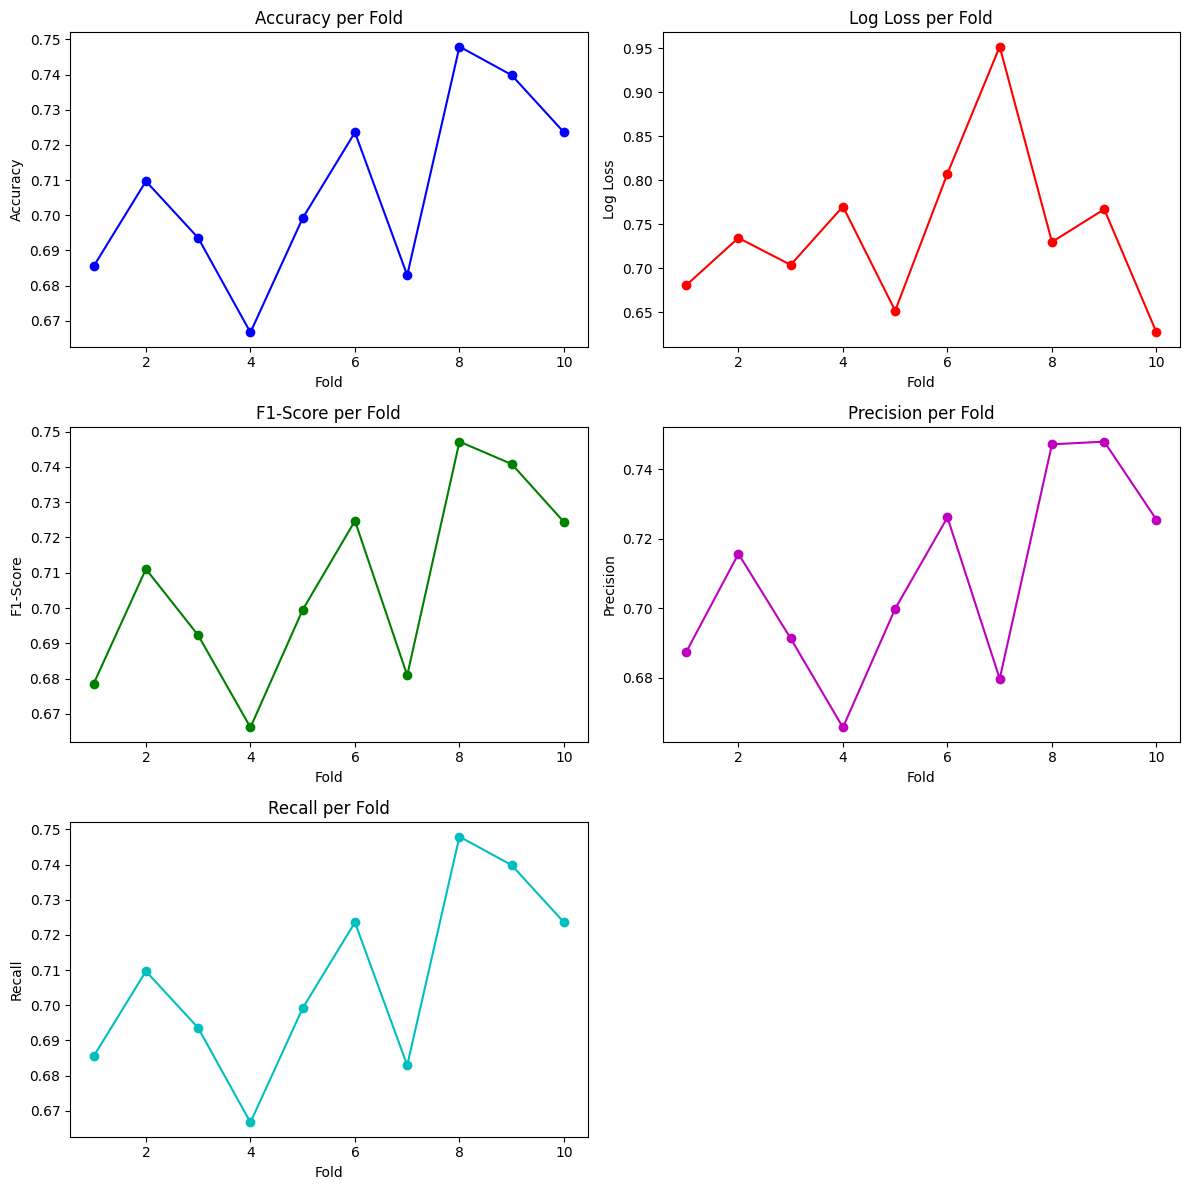


Average Accuracy: 0.7072
Average Log Loss: 0.7426
Average F1-Score: 0.7066
Average Precision: 0.7087
Average Recall: 0.7072


In [208]:
import matplotlib.pyplot as plt

# Plot the metrics for each fold
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(range(1, kf.get_n_splits() + 1), accuracies, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Accuracy per Fold")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("Accuracy")

# Log Loss plot
axes[0, 1].plot(range(1, kf.get_n_splits() + 1), log_losses, marker='o', linestyle='-', color='r')
axes[0, 1].set_title("Log Loss per Fold")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("Log Loss")

# F1-Score plot
axes[1, 0].plot(range(1, kf.get_n_splits() + 1), f1_scores, marker='o', linestyle='-', color='g')
axes[1, 0].set_title("F1-Score per Fold")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("F1-Score")

# Precision plot
axes[1, 1].plot(range(1, kf.get_n_splits() + 1), precisions, marker='o', linestyle='-', color='m')
axes[1, 1].set_title("Precision per Fold")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Precision")

# Recall plot
axes[2, 0].plot(range(1, kf.get_n_splits() + 1), recalls, marker='o', linestyle='-', color='c')
axes[2, 0].set_title("Recall per Fold")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("Recall")

# Hide empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print average metrics across all folds
print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"Average F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Average Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Average Recall: {sum(recalls)/len(recalls):.4f}")

## XGBoost Model with Vectorizer

In [199]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer  # Import TfidfVectorizer
import xgboost as xgb  # Import XGBoost
from sklearn.model_selection import KFold
import pickle

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
log_losses = []
f1_scores = []
precisions = []
recalls = []

# Initialize TfidfVectorizer and XGBoost classifier
vectorizer = TfidfVectorizer(max_features=500)  # Convert text to numerical features using TfidfVectorizer
clf = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)  # Using XGBoost classifier

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the vectorizer on the training data (fit on X_train)
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Train the classifier on the transformed training data
    clf.fit(X_train_vec, y_train)

    # Transform the test data using the fitted vectorizer (do not fit again)
    X_test_vec = vectorizer.transform(X_test)
    
    # Make predictions
    y_pred = clf.predict(X_test_vec)
    y_pred_proba = clf.predict_proba(X_test_vec)  # Probabilities for log loss
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba)
    log_losses.append(loss)
    
    # Calculate F1-score, precision, and recall
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Print average metrics across all folds
print(f"Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")

# Save the model and vectorizer
with open('xgboost/xgboost_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('xgboost/xgboost_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:54:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:54:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:54:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 


Accuracy: 0.7137
Log Loss: 0.6138
F1-Score: 0.7094
Precision: 0.7145
Recall: 0.7137


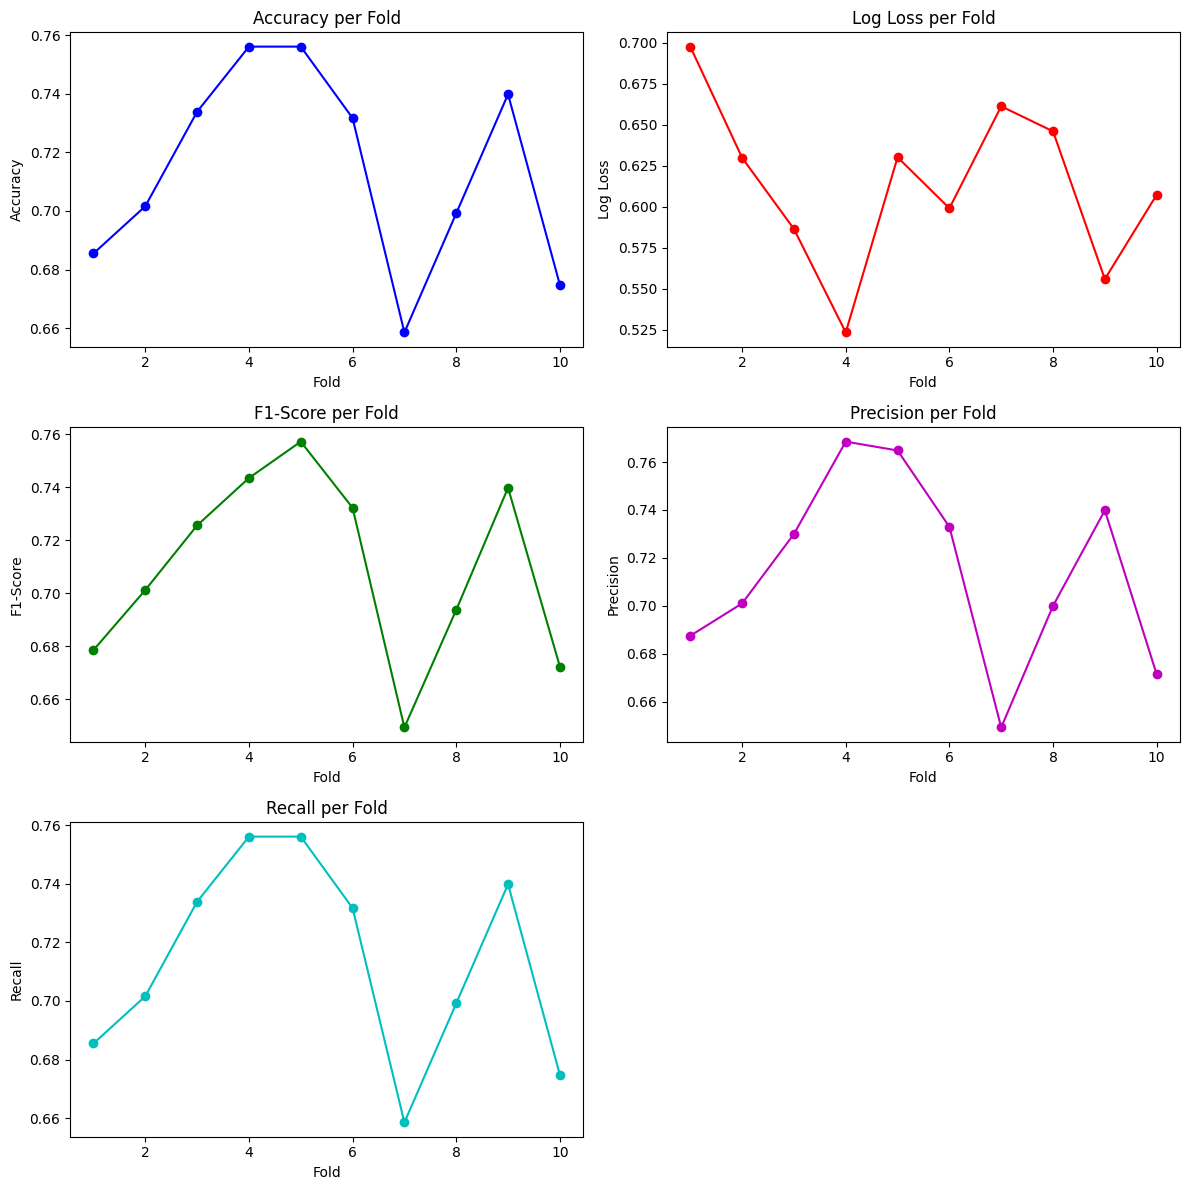


Average Accuracy: 0.7137
Average Log Loss: 0.6138
Average F1-Score: 0.7094
Average Precision: 0.7145
Average Recall: 0.7137


In [200]:
import matplotlib.pyplot as plt

# Plot the metrics for each fold
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(range(1, kf.get_n_splits() + 1), accuracies, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Accuracy per Fold")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("Accuracy")

# Log Loss plot
axes[0, 1].plot(range(1, kf.get_n_splits() + 1), log_losses, marker='o', linestyle='-', color='r')
axes[0, 1].set_title("Log Loss per Fold")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("Log Loss")

# F1-Score plot
axes[1, 0].plot(range(1, kf.get_n_splits() + 1), f1_scores, marker='o', linestyle='-', color='g')
axes[1, 0].set_title("F1-Score per Fold")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("F1-Score")

# Precision plot
axes[1, 1].plot(range(1, kf.get_n_splits() + 1), precisions, marker='o', linestyle='-', color='m')
axes[1, 1].set_title("Precision per Fold")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Precision")

# Recall plot
axes[2, 0].plot(range(1, kf.get_n_splits() + 1), recalls, marker='o', linestyle='-', color='c')
axes[2, 0].set_title("Recall per Fold")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("Recall")

# Hide empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print average metrics across all folds
print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"Average F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Average Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Average Recall: {sum(recalls)/len(recalls):.4f}")

## XGBoost Model with Count Vectorizer

In [197]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer  # Import CountVectorizer
import xgboost as xgb  # Import XGBoost
from sklearn.model_selection import KFold
import pickle

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
log_losses = []
f1_scores = []
precisions = []
recalls = []

# Initialize CountVectorizer and XGBoost classifier
vectorizer = CountVectorizer(max_features=500)  # Convert text to numerical features using CountVectorizer
clf = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)  # Using XGBoost classifier

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the vectorizer on the training data (fit on X_train)
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Train the classifier on the transformed training data
    clf.fit(X_train_vec, y_train)

    # Transform the test data using the fitted vectorizer (do not fit again)
    X_test_vec = vectorizer.transform(X_test)
    
    # Make predictions
    y_pred = clf.predict(X_test_vec)
    y_pred_proba = clf.predict_proba(X_test_vec)  # Probabilities for log loss
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba)
    log_losses.append(loss)
    
    # Calculate F1-score, precision, and recall
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Print average metrics across all folds
print(f"Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")

# Save the model and vectorizer
with open('xgboost/xgboost_cnt_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('xgboost/xgboost_cnt_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:54:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:54:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:54:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 


Accuracy: 0.7276
Log Loss: 0.5720
F1-Score: 0.7228
Precision: 0.7275
Recall: 0.7276


C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:54:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


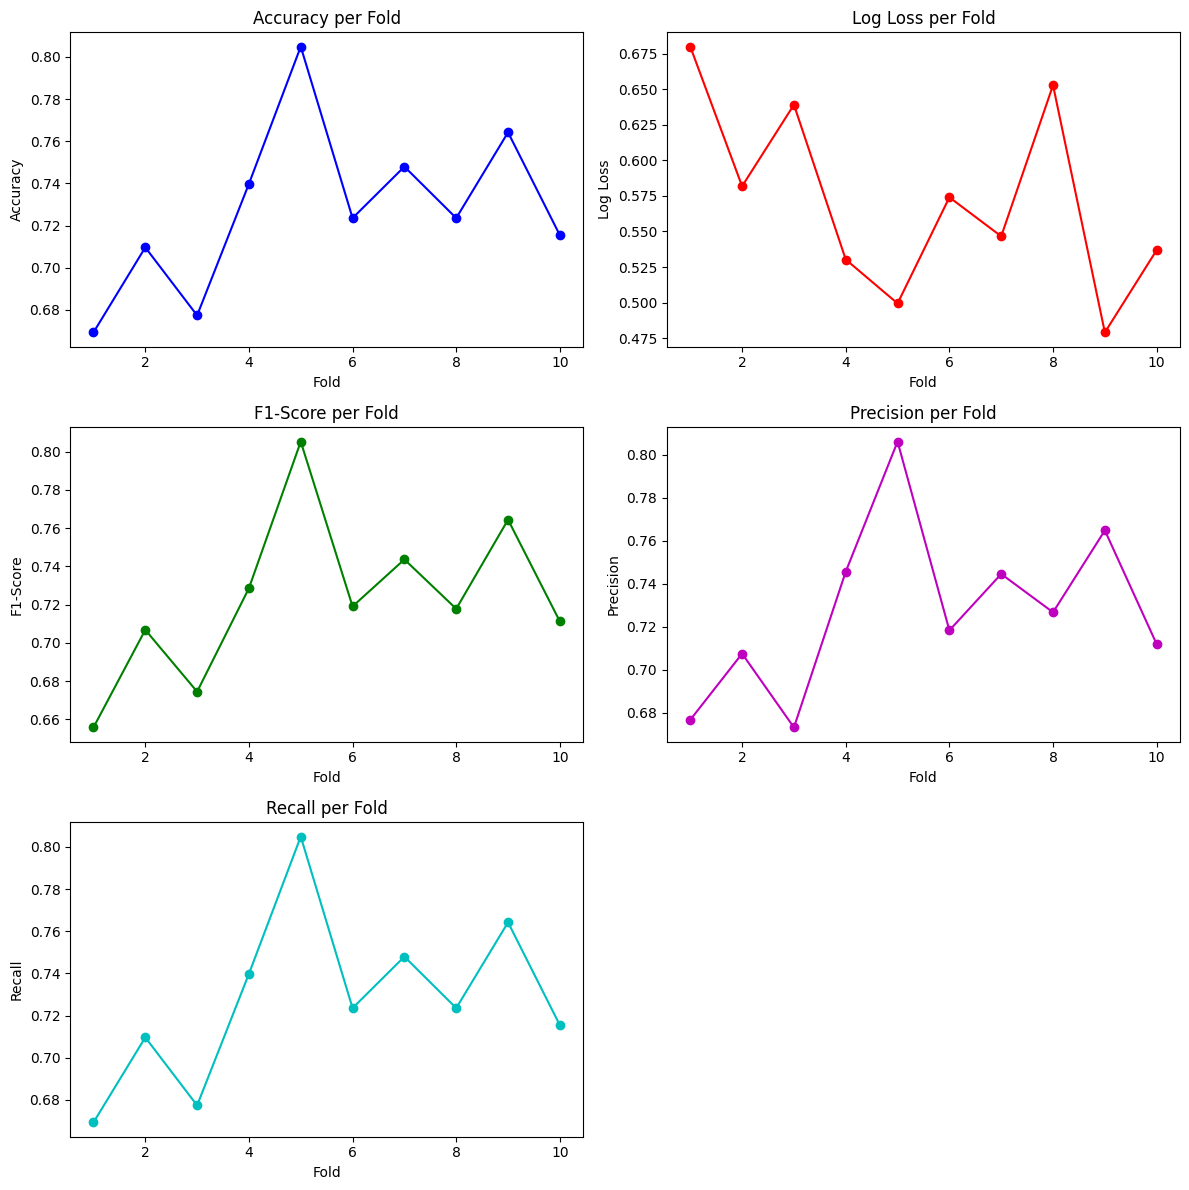


Average Accuracy: 0.7276
Average Log Loss: 0.5720
Average F1-Score: 0.7228
Average Precision: 0.7275
Average Recall: 0.7276


In [198]:
import matplotlib.pyplot as plt

# Plot the metrics for each fold
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(range(1, kf.get_n_splits() + 1), accuracies, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Accuracy per Fold")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("Accuracy")

# Log Loss plot
axes[0, 1].plot(range(1, kf.get_n_splits() + 1), log_losses, marker='o', linestyle='-', color='r')
axes[0, 1].set_title("Log Loss per Fold")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("Log Loss")

# F1-Score plot
axes[1, 0].plot(range(1, kf.get_n_splits() + 1), f1_scores, marker='o', linestyle='-', color='g')
axes[1, 0].set_title("F1-Score per Fold")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("F1-Score")

# Precision plot
axes[1, 1].plot(range(1, kf.get_n_splits() + 1), precisions, marker='o', linestyle='-', color='m')
axes[1, 1].set_title("Precision per Fold")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Precision")

# Recall plot
axes[2, 0].plot(range(1, kf.get_n_splits() + 1), recalls, marker='o', linestyle='-', color='c')
axes[2, 0].set_title("Recall per Fold")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("Recall")

# Hide empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print average metrics across all folds
print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"Average F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Average Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Average Recall: {sum(recalls)/len(recalls):.4f}")

## Bidirectional LSTM

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout, LSTM, Bidirectional, Input
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
X=data['complaint']

In [6]:
y=data['is_complaint']

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=5)

In [8]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)

In [9]:
max_length = data['tokenized_complaint'].apply(len).max()

In [10]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)

In [11]:
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length)

In [12]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [32]:
# Define the model
model = Sequential([
    Input(shape=(max_length,)),
    # Embedding layer with input_dim (vocab size) and output_dim (embedding size)
    Embedding(input_dim=50000, output_dim=8),  # 1500 words, 8-dimensional vectors

    # Bidirectional LSTM layer (LSTM layer wrapped in Bidirectional for better context)
    Bidirectional(LSTM(6, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),

    # Dropout layer to prevent overfitting
    Dropout(0.5),  # 50% dropout rate

    # Dense layer with L2 regularization
    Dense(4, activation='relu', kernel_regularizer=l2(0.025)),

    # Dropout to further regularize the model
    Dropout(0.5),  # 50% dropout rate

    # Output layer for binary classification (1 output neuron)
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

In [33]:
model.compile(optimizer=RMSprop(learning_rate=0.0025), loss='binary_crossentropy', metrics=['accuracy', F1Score()])

In [34]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 447, 8)              │         400,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 12)                  │             720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │              52 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 400,777 (1.53 MB)

 Trainable params: 400,777 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Reduce learning rate if validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=1, min_lr=5e-4)

# Train the model and store the history
history = model.fit(
    X_train_pad, y_train,  # Training data
    validation_data=(X_val_pad, y_val),  # Validation data
    epochs=25, 
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 284ms/step - accuracy: 0.5320 - f1_score: 0.2850 - loss: 0.8296 - val_accuracy: 0.5668 - val_f1_score: 0.0000e+00 - val_loss: 0.7849 - learning_rate: 0.0025
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 256ms/step - accuracy: 0.5903 - f1_score: 0.0000e+00 - loss: 0.7723 - val_accuracy: 0.5668 - val_f1_score: 0.0000e+00 - val_loss: 0.7472 - learning_rate: 0.0025
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - accuracy: 0.5992 - f1_score: 0.0000e+00 - loss: 0.7370 - val_accuracy: 0.5668 - val_f1_score: 0.0000e+00 - val_loss: 0.7208 - learning_rate: 0.0025
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step - accuracy: 0.5855 - f1_score: 0.0000e+00 - loss: 0.7112 - val_accuracy: 0.5668 - val_f1_score: 0.0000e+00 - val_loss: 0.7028 - learning_rate: 0.0025
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 396ms/step - accuracy: 0.6027 - f1_score: 0.0017 - loss: 0.6919 - val_accuracy: 0.5668 - val_f1_score: 0.0000e+00 - val_loss: 0.6928 - learning_rate: 0.

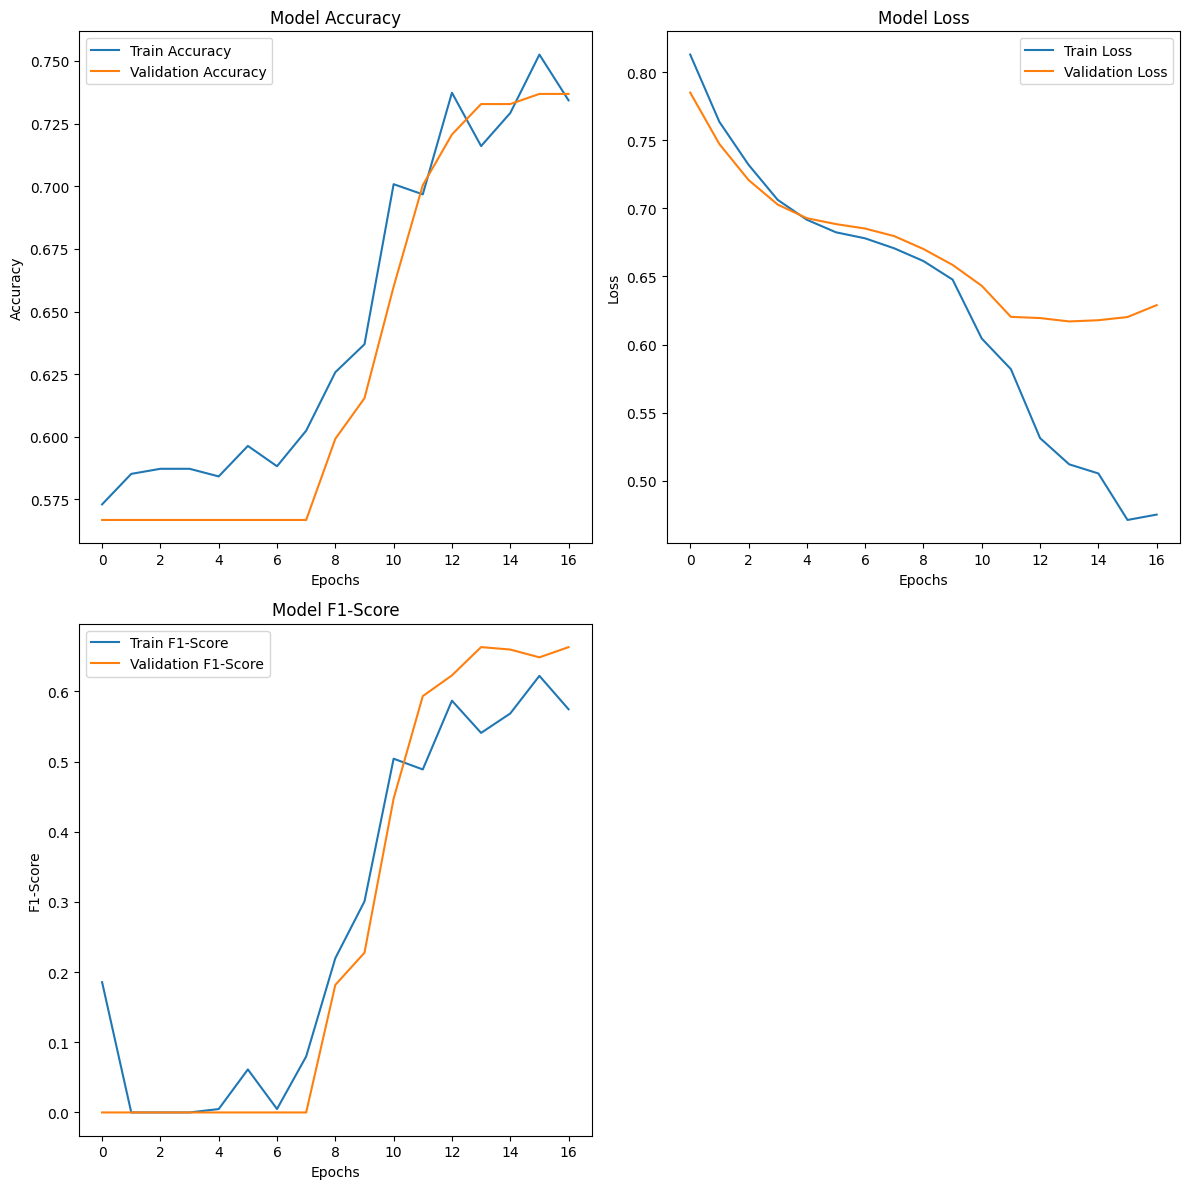

In [36]:
import matplotlib.pyplot as plt

# Plot the training and validation metrics
plt.figure(figsize=(12, 12))

# Plot Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot F1-Score
plt.subplot(2, 2, 3)
plt.plot(history.history['f1_score'], label='Train F1-Score')
plt.plot(history.history['val_f1_score'], label='Validation F1-Score')
plt.title('Model F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [37]:
# Save the model in SavedModel format
model.save('bidirectional_lstm/bidirectional_lstm_model.h5')

In [38]:
import json
# Save the word index
with open('bidirectional_lstm/word_index.json', 'w') as file:
    json.dump(tokenizer.word_index, file)

## BERT

In [224]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
model = TFAutoModelForSequenceClassification.from_pretrained("indolem/indobert-base-uncased", from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [223]:
X=data['complaint']

In [225]:
y=data['is_complaint']

In [226]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=5)

In [285]:
# Tokenize the datasets
train_encodings = tokenizer(list(X_train), truncation=True, padding="max_length", max_length=max_length)
val_encodings = tokenizer(list(X_val), truncation=True, padding="max_length", max_length=max_length)

In [319]:
def create_tf_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": tf.constant(encodings["input_ids"]),  # Force constant shapes
            "attention_mask": tf.constant(encodings["attention_mask"])
        },
        tf.constant(labels)  # Convert labels to constant tensors
    )).batch(4)  # Use a fixed batch size

train_dataset = create_tf_dataset(train_encodings, y_train.values)
val_dataset = create_tf_dataset(val_encodings, y_val.values)

In [320]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [321]:
class BertWrapper(tf.keras.layers.Layer):
    def __init__(self, bert_model):
        super(BertWrapper, self).__init__()
        self.bert = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return output.logits  # Output logits for classification

In [323]:
# Define the input layers for the Keras Functional API
input_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

# Wrap the BERT model with the custom layer
bert_output = BertWrapper(model)([input_ids, attention_mask])

# Add custom layers on top of the BERT model's output
dropout_layer = layers.Dropout(0.5)(bert_output)  # Dropout layer for regularization
dense_layer = layers.Dense(4, activation="relu")(dropout_layer)  # Fully connected layer
output_layer = layers.Dense(1, activation="sigmoid")(dense_layer)  # Output layer for binary classification

# Define the final model with custom layers
custom_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output_layer)

In [324]:
# Compile the model
custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                     loss='binary_crossentropy', 
                     metrics=['accuracy',F1Score()])

In [325]:
# Model summary to check the architecture
custom_model.summary()

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)        │ (None, 447)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_mask (InputLayer)   │ (None, 447)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_wrapper_16 (BertWrapper) │ (None, 2)                 │               0 │ input_ids[0][0],           │
│                               │                           │                 │ attention_mask[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_71 (Dropout)          │ (None, 2)                 │               0 │ bert_wrapper_16[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_86 (Dense)              │ (None, 4)                 │              12 │ dropout_71[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_87 (Dense)              │ (None, 1)                 │               5 │ dense_86[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)

In [326]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Reduce learning rate if validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-4)

# Train with callbacks
history = custom_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  # Train for up to 10 epochs
    batch_size=4,
    callbacks=[early_stopping, reduce_lr]  # Include the callbacks
)

Epoch 1/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 850s 3s/step - accuracy: 0.5131 - f1_score: 0.5353 - loss: 0.6940 - val_accuracy: 0.5668 - val_f1_score: 0.0000e+00 - val_loss: 0.6872 - learning_rate: 0.0010
Epoch 2/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 1046s 4s/step - accuracy: 0.5710 - f1_score: 0.0000e+00 - loss: 0.6862 - val_accuracy: 0.5668 - val_f1_score: 0.0000e+00 - val_loss: 0.6843 - learning_rate: 0.0010
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 905s 4s/step - accuracy: 0.5710 - f1_score: 0.0000e+00 - loss: 0.6836 - val_accuracy: 0.5668 - val_f1_score: 0.0000e+00 - val_loss: 0.6842 - learning_rate: 0.0010
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5709 - f1_score: 0.0000e+00 - loss: 0.6832

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the tokenizer to a directory
tokenizer.save_pretrained("BERT/indobert_tokenizer")

In [ ]:
# Save the model in SavedModel format
custom_model.save('BERT/indobert_model.keras')

## Test

In [39]:
df = pd.read_csv('../../scraper/data_x/merged_data.csv')

In [70]:
df

,complaint,category,tokenized_complaint
0,sisi istri neng lihat hujan pas ngalamin kerin...,lingkungan,"[420, 4017, 828, 193, 32, 48, 0, 61, 123, 8, 0..."
1,hidup miskin suka banget hujan pulang sekolah ...,fasilitas umum,"[23, 817, 44, 19, 32, 162, 106, 0, 11, 255, 41..."
2,oh mau umur hidup ga ngerasain hujan kah kalo ...,kekeringan,"[1119, 0, 3705, 23, 16, 592, 32, 520, 20, 0, 5..."
3,yosh irigasi dah ngalir bye bye arc kering pin...,kekeringan,"[0, 3059, 65, 1323, 3476, 3476, 0, 61, 460, 0,..."
4,suka kering gak air sih sumber air bumi krn si...,polusi,"[44, 61, 12, 6, 21, 195, 6, 742, 634, 0, 32]"
...,...,...,...
12188,administrasi bersih layan yg ramah tugas,layanan,"[3947, 33, 67, 8, 143, 194]"
12189,lahan sdh pakai taman dki hubung cp dinas huta...,hutan,"[149, 691, 88, 346, 422, 362, 2614, 208, 10, 4..."
12190,mohon bapakbapak ibuibu jabat dinas makam perh...,layanan,"[232, 0, 0, 157, 208, 0, 224, 0, 0, 1137, 73, ..."
12191,mibil dinas hilux parkir nyala mesin sopir nga...,limbah,"[0, 208, 0, 347, 0, 3717, 1326, 0, 363, 0, 0, 19]"


In [45]:
df['complaint'] = df['complaint'].apply(clean_complaint) 

In [46]:
df['complaint'] = df['complaint'].apply(remove_stopwords) 

In [47]:
with open('bidirectional_lstm/word_index.json', 'r', encoding='utf-8') as f:
    word_index = json.load(f)

def tokenize_complaint(complaint):
    words = complaint.split(' ')
    tokenized_complaint = [word_index.get(word, 0) for word in words]
    return tokenized_complaint

# Tokenize each complaint
df['tokenized_complaint'] = df['complaint'].apply(tokenize_complaint)

In [74]:
X = df['complaint']

In [75]:
X_train_seq = tokenizer.texts_to_sequences(X)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)

In [76]:
y = model.predict(X_train_pad)

382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step


In [88]:
indices = np.where(y >= 0.5)[0]
indices

array([    0,     1,     2, ..., 12179, 12189, 12190])

In [94]:
filtered_df = df.iloc[indices]
filtered_df

,complaint,category,tokenized_complaint
0,sisi istri neng lihat hujan pas ngalamin kerin...,lingkungan,"[420, 4017, 828, 193, 32, 48, 0, 61, 123, 8, 0..."
1,hidup miskin suka banget hujan pulang sekolah ...,fasilitas umum,"[23, 817, 44, 19, 32, 162, 106, 0, 11, 255, 41..."
2,oh mau umur hidup ga ngerasain hujan kah kalo ...,kekeringan,"[1119, 0, 3705, 23, 16, 592, 32, 520, 20, 0, 5..."
4,suka kering gak air sih sumber air bumi krn si...,polusi,"[44, 61, 12, 6, 21, 195, 6, 742, 634, 0, 32]"
5,dampak kering desa won beri edukasi masyarakat...,fasilitas umum,"[85, 61, 256, 0, 0, 548, 24, 96, 1050, 0, 1362..."
...,...,...,...
12172,instansi perintah kota ternate tugas urus tata...,lainnya,"[1971, 57, 40, 0, 194, 177, 473, 346, 33, 40]"
12177,assalamualaikum pohon pohon tua tebang serampa...,hutan,"[1272, 70, 70, 646, 932, 0, 41, 70, 239, 3046,..."
12179,assalamualaikum dinas taman kota dki jakarta j...,hutan,"[1272, 208, 346, 40, 422, 84, 84, 616, 145, 42..."
12189,lahan sdh pakai taman dki hubung cp dinas huta...,hutan,"[149, 691, 88, 346, 422, 362, 2614, 208, 10, 4..."


In [95]:
# Save the selected columns to a new CSV file
filtered_columns.to_csv('../../model/category_detection/category_training_data.csv', index=False)

NameError: name 'filtered_columns' is not defined